<a href="https://colab.research.google.com/github/dguevaraapaza/H1N1-Seasonal-Flu-Vaccine/blob/main/H1N1_and_seasonal_flu_vaccines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vaccination Prediction


> **Goal:** Predict how likely individuals are to receive their H1N1 and seasonal flu vaccines. In specific, the target is to predict two probabilities: one for h1n1_vaccine and one for seasonal_vaccine.

**This is a multi-label classification problem.**

In [72]:
# !pip install -q pandas
# !pip install -q numpy
# !pip install -q matplotlib
# !pip install -q scikit-learn
# !pip install -q seaborn
# !pip install -q missingno
# !pip install -q fancyimpute
# !pip install scikit-multilearn

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Libraries for Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.decomposition import PCA

# Libraries for model training
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split , GridSearchCV , cross_val_score

# Libraries for Problem Transformation
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import LabelPowerset

# Libraries for algorithm
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

# Impute binary data
from fancyimpute import IterativeImputer

# Libraries for testing
from sklearn.metrics import accuracy_score , classification_report, f1_score, confusion_matrix

# Removing warnings
import warnings
warnings.filterwarnings('ignore')

#Check missing values
import missingno as msno

# Storing plots
%matplotlib inline

In [74]:
# Load data
vac = pd.read_csv('/content/sample_data/fixed_H1N1_Flu_Vaccines.csv', index_col='respondent_id', delimiter=',')
display(vac.head())
print(f'Dataset strcuture: {vac.shape}')

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,h1n1_vaccine,seasonal_vaccine
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0,0,0,0,0,1,1,0,...,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,0,0
1,3.0,2.0,0,1,0,1,0,1,1,0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,0,1
2,1.0,1.0,0,1,0,0,0,0,0,0,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,0,0
3,1.0,1.0,0,1,0,1,1,0,0,0,...,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,0,1
4,2.0,1.0,0,1,0,1,1,0,1,0,...,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,0,0


Dataset strcuture: (25098, 34)


In [75]:
# group variables for imputation
h1n1_concern = ['h1n1_concern', 'h1n1_knowledge'] # categorical
behaviour = ['behavioral_antiviral_meds', 'behavioral_avoidance', 'behavioral_face_mask',
             'behavioral_wash_hands', 'behavioral_large_gatherings', 'behavioral_outside_home',
             'behavioral_touch_face'] #binary
recomendation = ['doctor_recc_h1n1', 'doctor_recc_seasonal'] #binary
health_condition = ['chronic_med_condition', 'child_under_6_months', 'health_worker'] #, 'health_insurance'] #Binary
opinion = ['opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
           'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
           'opinion_seas_risk', 'opinion_seas_sick_from_vacc'] # categorical
demographics = ['age_group','education', 'race', 'sex', 'income_poverty',
                'marital_status', 'rent_or_own', 'employment_status'] #, 'employment_industry', 'employment_occupation'] # categorical
household_info = ['hhs_geo_region', 'census_msa', 'household_adults',
                  'household_children'] # categorical
predictors = ['h1n1_vaccine', 'seasonal_vaccine'] # predictor variables

# variable to impute
cat_variable = h1n1_concern + opinion + demographics + household_info
bin_variable = behaviour + recomendation + health_condition

## **1. Data preprocessing**

In [76]:
# Prepare datasets
labels = vac[predictors] # (26707, 2)
features = vac.drop(predictors, axis=1) # (26707, 35)

In [77]:
# Encoding the categorical features
enc = LabelEncoder()
for col in cat_variable:
	features[col] = enc.fit_transform(features[col])

# One-hot encoding the categorical variables
features = pd.get_dummies(features, columns=cat_variable, drop_first=True, dtype='int64')

In [78]:
# Expliting train and test data
X = features
y = labels

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 2. **Feature Selection**

In [79]:
# # ExtraTreesClassifier
model = ExtraTreesClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Compute feature importances
importances = model.feature_importances_

# Create a DataFrame for feature importances
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances})

# Get the top 30 features with the highest importances
top_features = feature_importances.nlargest(35, 'Importance')['Feature']

# Select only the top features
X_selected = X[top_features]

print("Transformed Data Shape:", X_selected.shape)

Transformed Data Shape: (25098, 35)


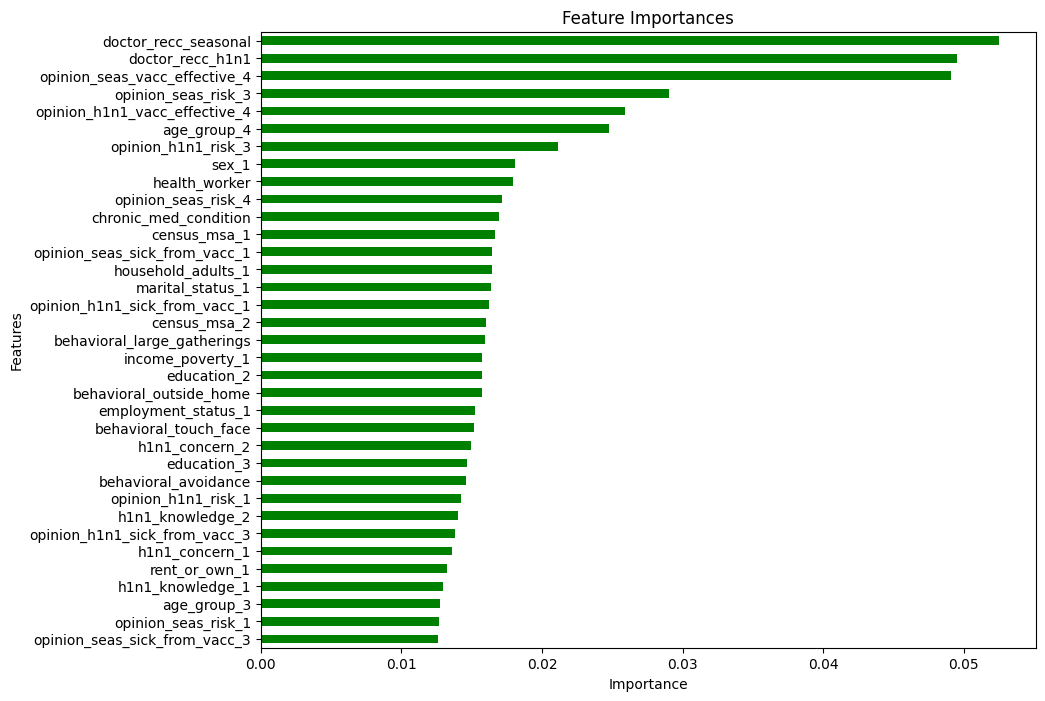

In [80]:
# Plotting the feature importances
plt.figure(figsize=(10, 8))
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(35).sort_values(ascending=True).plot(kind='barh', color='green')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importances')
plt.show()

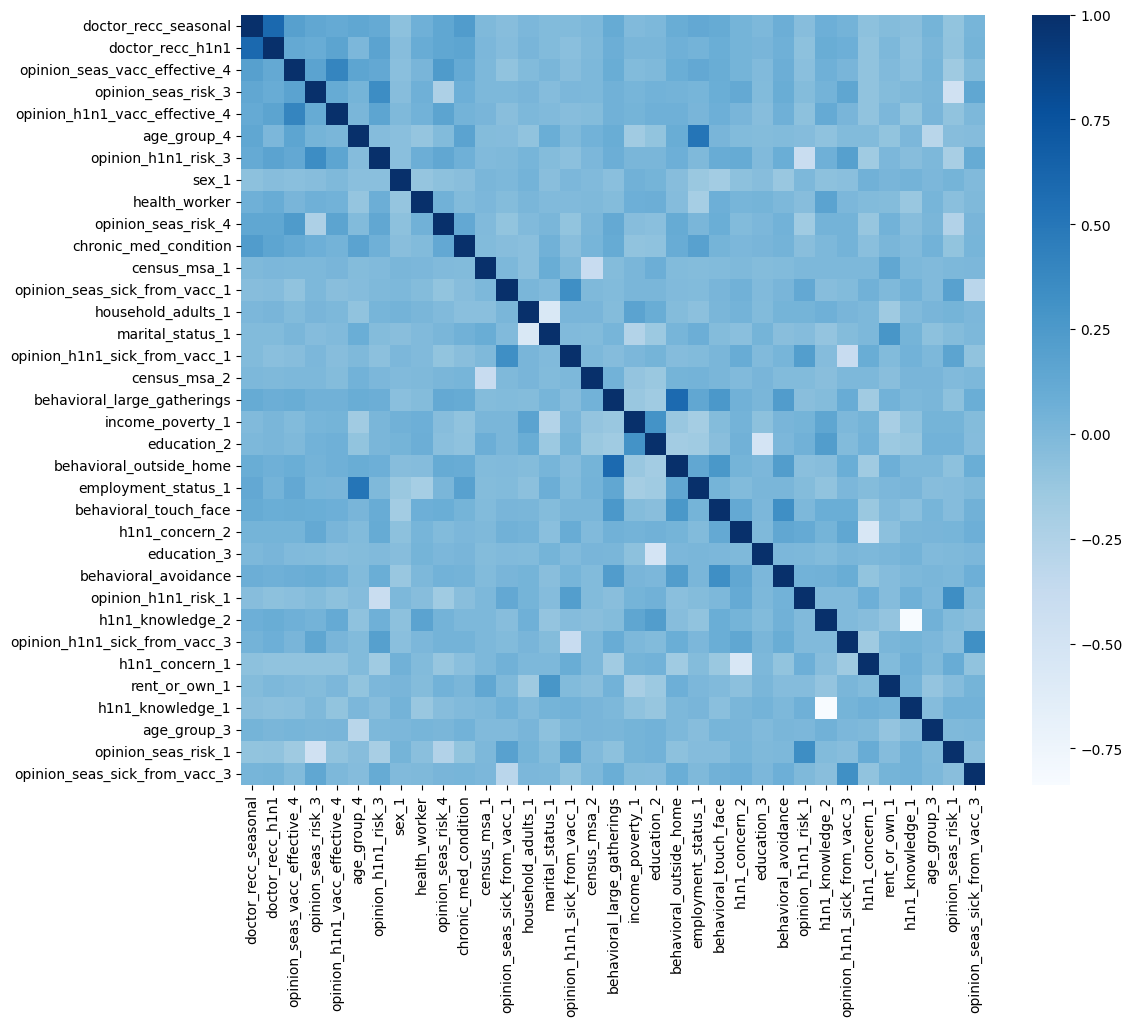

In [81]:
#get correlations of each features in dataset
corrmat = features[top_features].corr()
top_corr_features = corrmat.index
plt.figure(figsize=(12,10))
#plot heat map
g=sns.heatmap(features[top_corr_features].corr(),annot=False,cmap="Blues")

In [82]:
# Select only the top features
X_trainft = X_train[top_features]
X_testft = X_test[top_features]

## **3. Modeling**

In [ ]:
# Store everything in a dataframe
results_df = pd.DataFrame(columns=['Model', 'Accuracy'])

# create a function to print results
def evaluate_model(model_name, xtrain, ytrain, xtest, ytest, model, df):
    model.fit(xtrain, ytrain)
    y_pred = model.predict(xtest)
    accuracy = accuracy_score(ytest, y_pred)
    print(f"Model\t\t: {model_name}")
    print(f"Accuracy\t: {accuracy}")
    print("\n")
    print(classification_report(ytest, y_pred, zero_division=1))

    # Convert true labels and predictions to binary format (if not already NumPy arrays)
    y_test_np = ytest.to_numpy() if isinstance(ytest, pd.DataFrame) else ytest
    y_pred_np = y_pred.to_numpy() if isinstance(y_pred, pd.DataFrame) else y_pred

    # Multi-label confusion matrix
    cm = multilabel_confusion_matrix(y_test_np, y_pred_np)
    label_names = ['h1n1_vaccine', 'seasonal_vaccine']
    for i, matrix in enumerate(cm):
        plt.figure(figsize=(6, 4))
        sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'],
                    yticklabels=['No', 'Yes'])
        plt.title(f'Confusion Matrix for {label_names[i]} - {model_name}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

    return pd.DataFrame({'Model': [model_name], 'Accuracy': [accuracy]})

### a. Binary Relevance - Naive Bayes

Model		: Binary Relevance - Gaussian Naive Bayes
Accuracy	: 0.6073705179282869


              precision    recall  f1-score   support

           0       0.48      0.62      0.54      1066
           1       0.72      0.71      0.72      2326

   micro avg       0.64      0.68      0.66      3392
   macro avg       0.60      0.66      0.63      3392
weighted avg       0.65      0.68      0.66      3392
 samples avg       0.84      0.83      0.69      3392



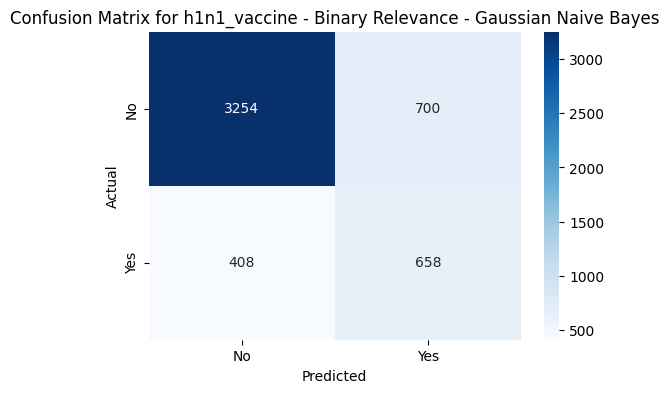

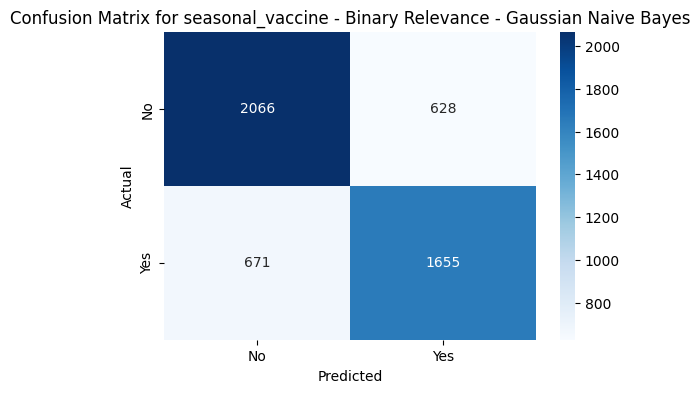

In [84]:
# Gaussian Naive Bayes
model_BR_GNB = BinaryRelevance(GaussianNB())

# Evaluate model
new = evaluate_model('Binary Relevance - Gaussian Naive Bayes', X_trainft, y_train, X_testft, y_test, model_BR_GNB, results_df)

# Append results
results_df = pd.concat([results_df, new], ignore_index=True)


### b. Binary Relevance - Decision Tree

Model		: Binary Relevance - Decision Tree
Accuracy	: 0.5123505976095617


              precision    recall  f1-score   support

           0       0.41      0.46      0.43      1066
           1       0.64      0.64      0.64      2326

   micro avg       0.56      0.59      0.57      3392
   macro avg       0.52      0.55      0.54      3392
weighted avg       0.57      0.59      0.58      3392
 samples avg       0.75      0.79      0.60      3392



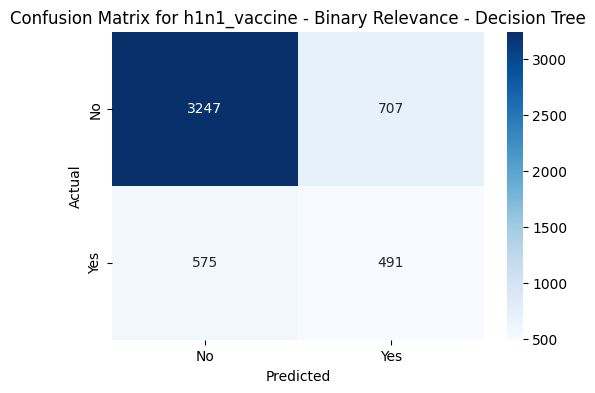

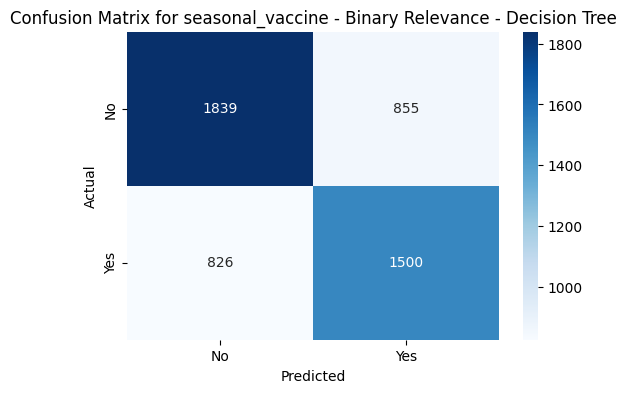

In [85]:
# Decision tree
model_BR_DT = BinaryRelevance(DecisionTreeClassifier())

# Evaluate model
new = evaluate_model('Binary Relevance - Decision Tree', X_trainft, y_train, X_testft, y_test, model_BR_DT, results_df)

# Append results
results_df = pd.concat([results_df, new], ignore_index=True)

### c. Binary Relevance - Logistic Regression

Model		: Binary Relevance - Logistic Regression
Accuracy	: 0.6549800796812749


              precision    recall  f1-score   support

           0       0.66      0.39      0.49      1066
           1       0.77      0.73      0.75      2326

   micro avg       0.74      0.62      0.68      3392
   macro avg       0.71      0.56      0.62      3392
weighted avg       0.73      0.62      0.67      3392
 samples avg       0.88      0.81      0.72      3392



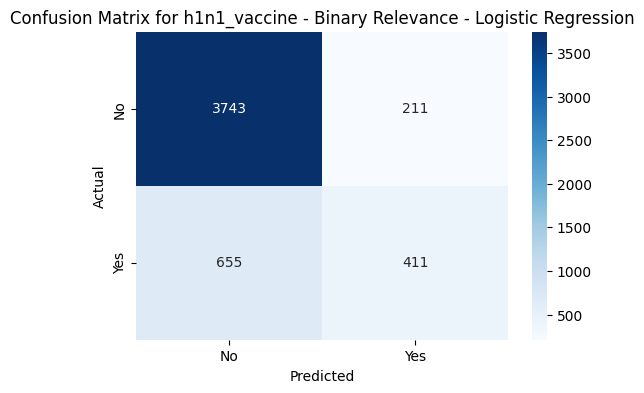

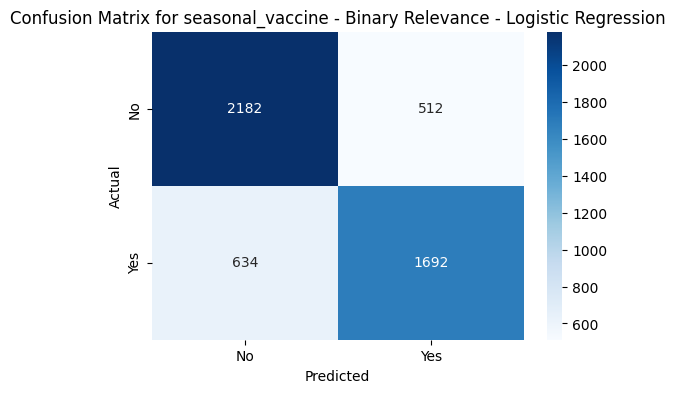

In [86]:
# Logistic Regression
model_BR_LR = BinaryRelevance(LogisticRegression())

# Evaluate model
new = evaluate_model('Binary Relevance - Logistic Regression', X_trainft, y_train, X_testft, y_test, model_BR_LR, results_df)

# Append results
results_df = pd.concat([results_df, new], ignore_index=True)

### d. Classifier Chains - Naive Bayes

Model		: Classifier Chain - Gaussian Naive Bayes
Accuracy	: 0.6049800796812749


              precision    recall  f1-score   support

           0       0.48      0.62      0.54      1066
           1       0.74      0.64      0.69      2326

   micro avg       0.64      0.63      0.63      3392
   macro avg       0.61      0.63      0.61      3392
weighted avg       0.66      0.63      0.64      3392
 samples avg       0.86      0.80      0.68      3392



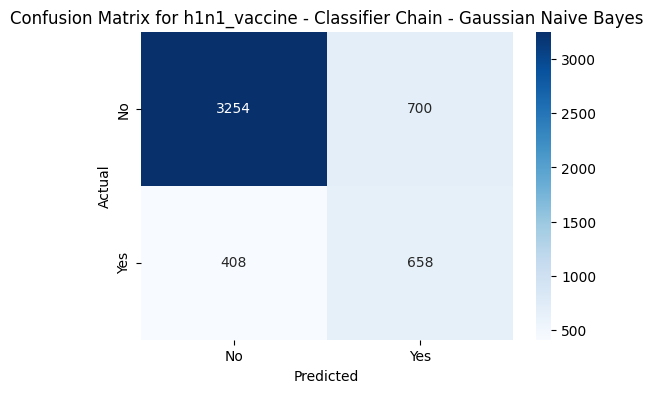

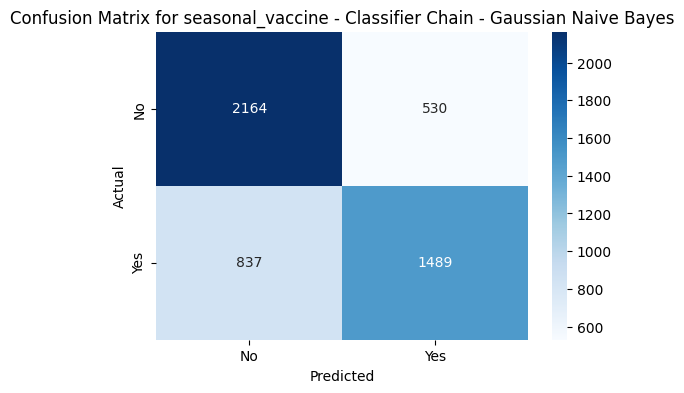

In [87]:
# Gaussian Naive Bayes
model_CC_GNB = ClassifierChain(GaussianNB())

# Evaluate model
new = evaluate_model('Classifier Chain - Gaussian Naive Bayes', X_trainft, y_train, X_testft, y_test, model_CC_GNB, results_df)

# Append results
results_df = pd.concat([results_df, new], ignore_index=True)

### e. Classifier Chains - Decision Tree

Model		: Classifier Chain - Decision Tree
Accuracy	: 0.5322709163346614


              precision    recall  f1-score   support

           0       0.40      0.46      0.43      1066
           1       0.65      0.67      0.66      2326

   micro avg       0.57      0.61      0.59      3392
   macro avg       0.53      0.57      0.55      3392
weighted avg       0.57      0.61      0.59      3392
 samples avg       0.77      0.80      0.61      3392



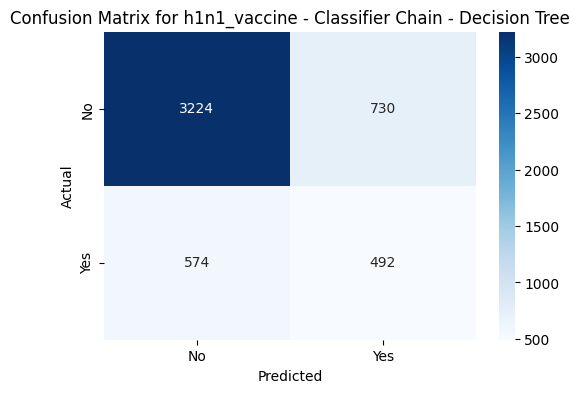

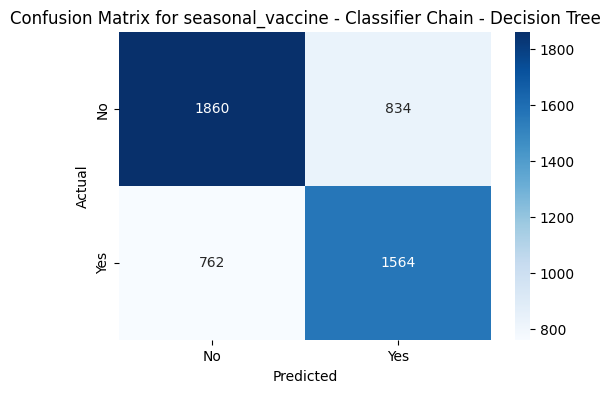

In [88]:
# Decision tree
model_CC_DT = ClassifierChain(DecisionTreeClassifier())

# Evaluate model
new = evaluate_model('Classifier Chain - Decision Tree', X_trainft, y_train, X_testft, y_test, model_CC_DT, results_df)

# Append results
results_df = pd.concat([results_df, new], ignore_index=True)

### f. Classifier Chains - Logistic Regression

Model		: Classifier Chain - Logistic Regression
Accuracy	: 0.6623505976095617


              precision    recall  f1-score   support

           0       0.66      0.39      0.49      1066
           1       0.79      0.67      0.72      2326

   micro avg       0.76      0.58      0.66      3392
   macro avg       0.73      0.53      0.61      3392
weighted avg       0.75      0.58      0.65      3392
 samples avg       0.91      0.79      0.72      3392



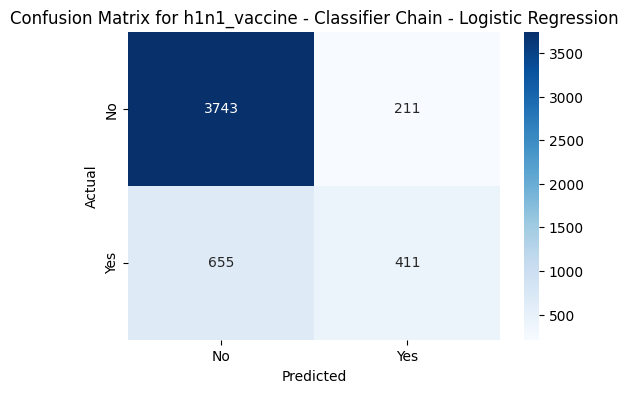

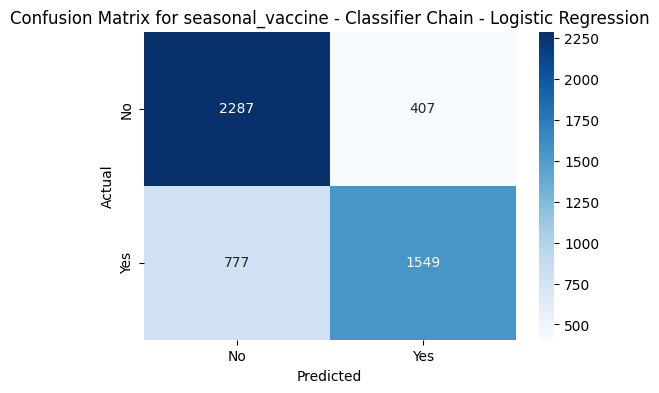

In [89]:
# Logistics regression
model_CC_LR = ClassifierChain(LogisticRegression())

# Evaluate model
new = evaluate_model('Classifier Chain - Logistic Regression', X_trainft, y_train, X_testft, y_test, model_CC_LR, results_df)

# Append results
results_df = pd.concat([results_df, new], ignore_index=True)

### g. Label Powerset - Naive Bayes

Model		: Label Powerset - Gaussian Naive Bayes
Accuracy	: 0.6241035856573706


              precision    recall  f1-score   support

           0       0.51      0.59      0.54      1066
           1       0.73      0.73      0.73      2326

   micro avg       0.65      0.69      0.67      3392
   macro avg       0.62      0.66      0.64      3392
weighted avg       0.66      0.69      0.67      3392
 samples avg       0.84      0.84      0.70      3392



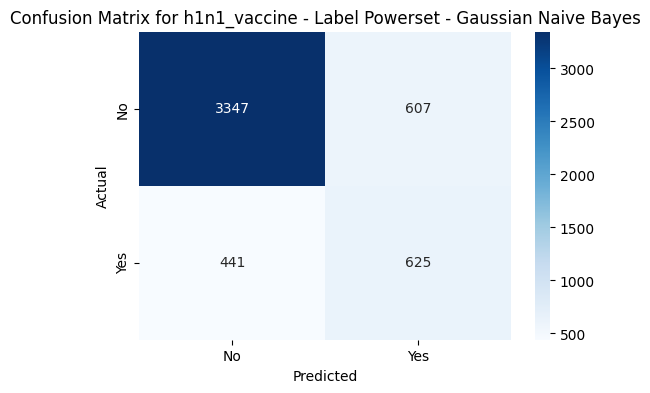

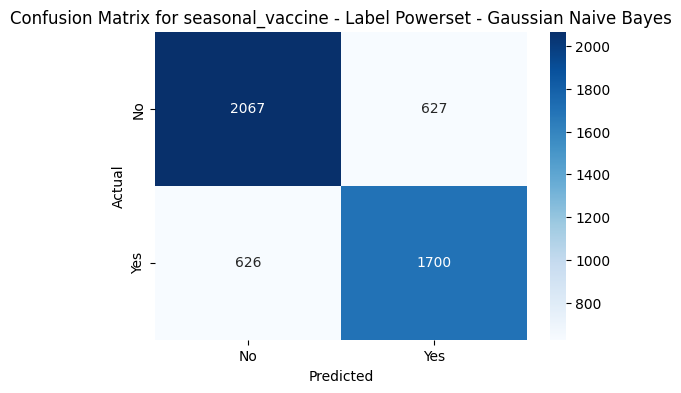

In [90]:
# Gaussian Naive Bayes
model_LP_GNB = LabelPowerset(GaussianNB())

# Evaluate model
new = evaluate_model('Label Powerset - Gaussian Naive Bayes', X_trainft, y_train, X_testft, y_test, model_LP_GNB, results_df)

# Append results
results_df = pd.concat([results_df, new], ignore_index=True)

### h. Label Powerset - Decision Tree

Model		: Label Powerset - Decision Tree
Accuracy	: 0.5390438247011953


              precision    recall  f1-score   support

           0       0.41      0.44      0.42      1066
           1       0.65      0.67      0.66      2326

   micro avg       0.57      0.60      0.58      3392
   macro avg       0.53      0.55      0.54      3392
weighted avg       0.57      0.60      0.58      3392
 samples avg       0.78      0.80      0.62      3392



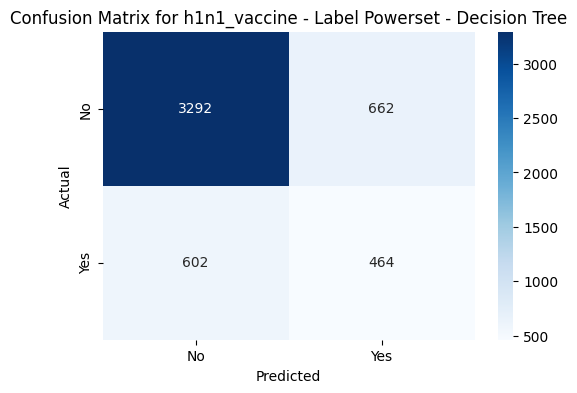

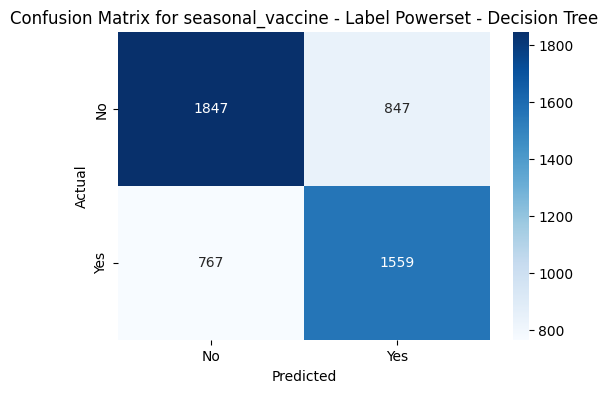

In [91]:
# Initializing
model_LP_DT = LabelPowerset(DecisionTreeClassifier())

# Evaluate model
new = evaluate_model('Label Powerset - Decision Tree', X_trainft, y_train, X_testft, y_test, model_LP_DT, results_df)

# Append results
results_df = pd.concat([results_df, new], ignore_index=True)

### i. Random Forest

Model		: Random Forest
Accuracy	: 0.6396414342629482


              precision    recall  f1-score   support

           0       0.66      0.35      0.46      1066
           1       0.75      0.73      0.74      2326

   micro avg       0.73      0.61      0.67      3392
   macro avg       0.71      0.54      0.60      3392
weighted avg       0.72      0.61      0.65      3392
 samples avg       0.87      0.81      0.71      3392



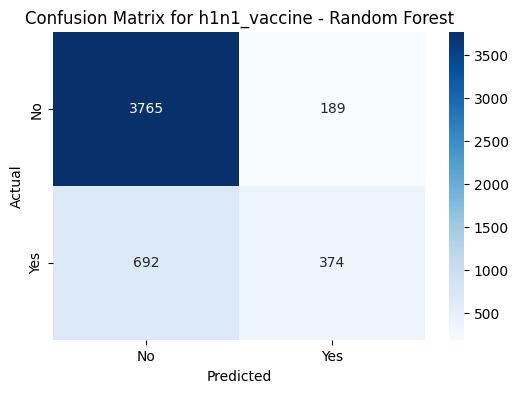

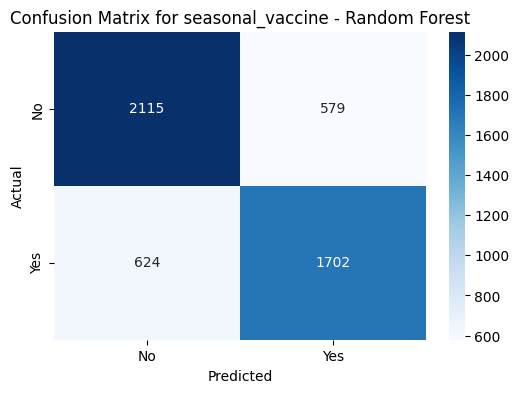

In [92]:
# Initializing
model_RF = RandomForestClassifier()

# Evaluate model
new = evaluate_model('Random Forest', X_trainft, y_train, X_testft, y_test, model_RF, results_df)

# Append results
results_df = pd.concat([results_df, new], ignore_index=True)

## **4. Model Evaluation**

In [93]:
# Reviewing accuracy
results_df.sort_values(by='Accuracy', ascending=True, inplace=True)

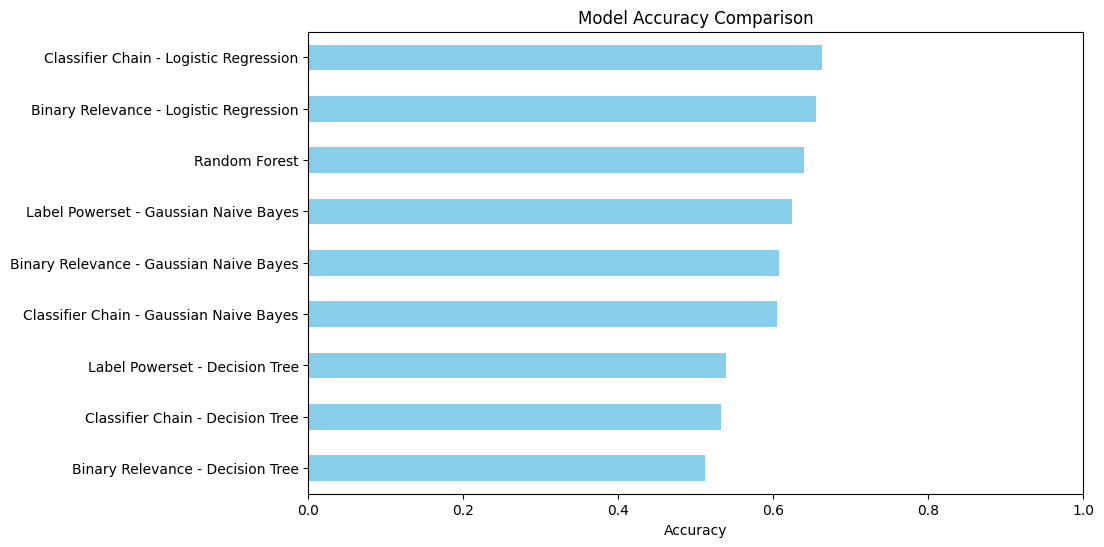

In [94]:
# Plotting the accuracy of different models
plt.figure(figsize=(10, 6))
results_df.set_index('Model')['Accuracy'].plot(kind='barh', legend=False, color='skyblue')
plt.xlabel('Accuracy')
plt.ylabel('')
plt.title('Model Accuracy Comparison')
plt.xlim(0, 1)
plt.show()